# Análisis de los resultados del modelado para Máster

En este análisis se realiza un análisis de los resultados obtenidos con el modelo realizado para los alumnos de Máster.

En este sentido, se ha realizado lo siguiente:

1. Se obtienen las métricas del modelo en el conjunto test.
2. Se observa la matriz de confusión para los matriculados y no matriculados, comparando el real con el predicho.
3. Se comparan las tasas de matriculación obtenidas con el predicho y las reales en las 5 principales titulaciones.
4. Se analizan las distribuciones de la probabilidad en cada una de las distintas etapas.
5. Se mira las distribuciones de la probabilidad de matrícula en las 5 titulaciones top.
6. Se mira la importancia de las variables dentro del modelo utilizado.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Cargar datos
df = pd.read_excel(r'C:\Users\0017655\Downloads\test_master_completo_con_scoring 8.xlsx')

# Configuración estética
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings

# Configuración de limpieza y estilo
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (16, 9)

# --- PROCESAMIENTO DE DATOS ---
# 1. Limpieza de nombres de etapa
df['STAGENAME'] = df['STAGENAME'].astype(str).str.strip()
df['prediction_score'] = 1-df['probabilidad_matricula']
# 2. Transformación a Probabilidad Real de Matrícula (Escala 0 a 1)
# Si el modelo predice 0 (No matrícula), la prob. real es (1 - score de confianza)
df['prob_matricula_real'] = df.apply(
    lambda x: x['prediction_score'] if x['prediction_label'] == 1 else (1 - x['prediction_score']), 
    axis=1
)

# 3. Definición de Segmentos para Análisis de Bajas
def definir_estado(row):
    if row['desmatriculado'] == 1 and row['target'] == 0:
        return 'Desmatriculado (Baja)'
    if row['target'] == 1:
        return 'Matriculado Activo'
    return 'No Matriculado'

df['estado_final'] = df.apply(definir_estado, axis=1)
df.to_excel(r'C:\Users\0017655\Downloads\test_master_completo_con_scoring 3_prob_real.xlsx')

KeyError: 'probabilidad_matricula'

## 1. Resultados globales del modelo de Grado

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def analizar_virtudes_modelo(df):
    """
    Calcula y presenta las métricas clave de rendimiento del modelo 
    enfocadas a la toma de decisiones en Admisiones.
    """
    y_real = df['target']
    y_pred = df['prediction_label']
    y_prob = df['prob_matricula_real']
    
    # Cálculos técnicos
    acc = accuracy_score(y_real, y_pred)
    prec = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    f1 = f1_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)
    
    # Matriz para cálculo de especificidad
    tn, fp, fn, tp = confusion_matrix(y_real, y_pred).ravel()
    especificidad = tn / (tn + fp)

    print("-" * 50)
    print("      VIRTUDES Y MÉTRICAS DEL MODELO DE ADMISIÓN")
    print("-" * 50)
    print(f"✅ Porcentaje de Acierto (Accuracy): {acc:.2%}")
    print(f"🎯 Capacidad de Discriminación (AUC-ROC): {auc:.4f}")
    print(f"📊 Precisión (Cuando predice Sí, ¿cuánto acierta?): {prec:.2%}")
    print(f"📈 Sensibilidad (¿A cuántos del total captura?): {rec:.2%}")
    print(f"🛡️ Especificidad (Capacidad de detectar No-Matrícula): {especificidad:.2%}")
    print("-" * 50)
    
    # Interpretación estratégica para el informe
    print("\nANÁLISIS ESTRATÉGICO:")
    if auc > 0.9:
        print("⭐ El modelo tiene un rendimiento EXCELENTE. La separación entre perfiles es muy clara.")
    elif auc > 0.8:
        print("👍 El modelo es ROBUSTO y fiable para la planificación financiera y de plazas.")
        
    print(f"💡 De cada 100 matrículas reales, el modelo identifica correctamente a {int(rec*100)} candidatos.")
    print(f"💡 El modelo es especialmente bueno descartando (Especificidad: {especificidad:.2%}), lo que ahorra esfuerzo comercial.")
    print("-" * 50)

# Ejecución de la función
analizar_virtudes_modelo(df)

--------------------------------------------------
      VIRTUDES Y MÉTRICAS DEL MODELO DE ADMISIÓN
--------------------------------------------------
✅ Porcentaje de Acierto (Accuracy): 91.90%
🎯 Capacidad de Discriminación (AUC-ROC): 0.9686
📊 Precisión (Cuando predice Sí, ¿cuánto acierta?): 93.63%
📈 Sensibilidad (¿A cuántos del total captura?): 92.50%
🛡️ Especificidad (Capacidad de detectar No-Matrícula): 91.05%
--------------------------------------------------

ANÁLISIS ESTRATÉGICO:
⭐ El modelo tiene un rendimiento EXCELENTE. La separación entre perfiles es muy clara.
💡 De cada 100 matrículas reales, el modelo identifica correctamente a 92 candidatos.
💡 El modelo es especialmente bueno descartando (Especificidad: 91.05%), lo que ahorra esfuerzo comercial.
--------------------------------------------------


## 2. Matriz de confusión global

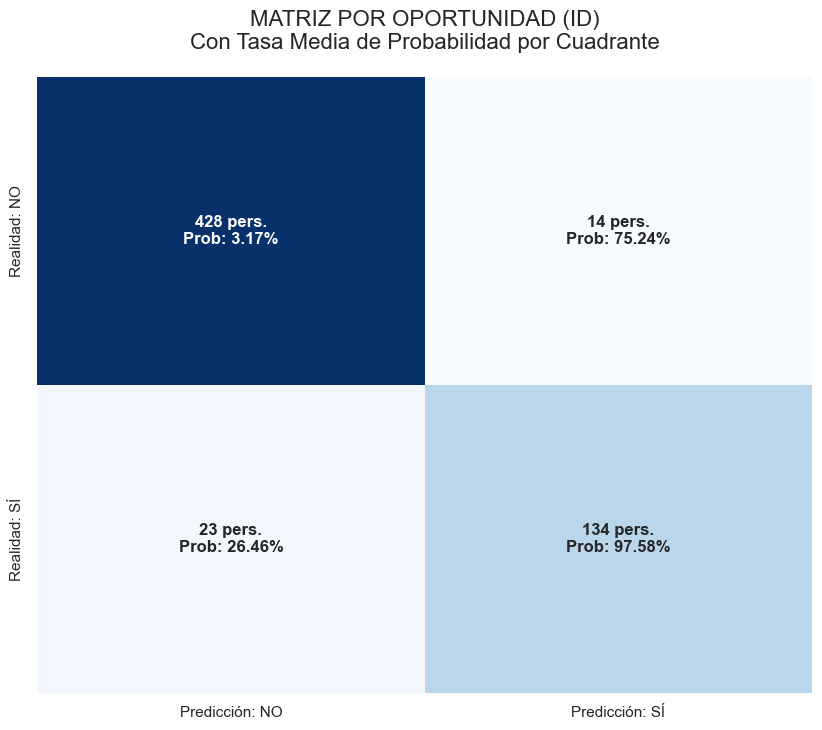

Exactitud (Accuracy): 93.82%
Precisión (Certeza de Matrícula): 90.54%


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# 1. Calculamos la probabilidad media por oportunidad (ID)
# Esto colapsa todas las etapas de un mismo alumno en un solo valor de propensión
df_oportunidades = df.groupby('ID').agg({
    'target': 'max',             # Si se matriculó en alguna etapa, es 1
    'prediction_label': 'max',    # Si el modelo predijo matrícula en alguna etapa
    'prob_matricula_real': 'mean' # Tasa media de probabilidad del alumno
}).reset_index()

# 2. Calculamos la matriz de confusión basada en IDs Únicos (Personas, no etapas)
cm = confusion_matrix(df_oportunidades['target'], df_oportunidades['prediction_label'])

# 3. Calculamos la tasa media de probabilidad para cada cuadrante de la matriz
tasa_cuadrantes = []
for real in [0, 1]:
    fila = []
    for pred in [0, 1]:
        mask = (df_oportunidades['target'] == real) & (df_oportunidades['prediction_label'] == pred)
        valor_medio = df_oportunidades[mask]['prob_matricula_real'].mean()
        fila.append(valor_medio)
    tasa_cuadrantes.append(fila)

# 4. Visualización
plt.figure(figsize=(10, 8))
# Usamos annot para poner tanto el conteo de personas como su probabilidad media
labels = [
    [f"{cm[0,0]} pers.\nProb: {tasa_cuadrantes[0][0]:.2%}", f"{cm[0,1]} pers.\nProb: {tasa_cuadrantes[0][1]:.2%}"],
    [f"{cm[1,0]} pers.\nProb: {tasa_cuadrantes[1][0]:.2%}", f"{cm[1,1]} pers.\nProb: {tasa_cuadrantes[1][1]:.2%}"]
]

sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', cbar=False,
            xticklabels=['Predicción: NO', 'Predicción: SÍ'],
            yticklabels=['Realidad: NO', 'Realidad: SÍ'],
            annot_kws={"size": 12, "weight": "bold"})

plt.title('MATRIZ POR OPORTUNIDAD (ID)\nCon Tasa Media de Probabilidad por Cuadrante', fontsize=16, pad=20)
plt.show()

# Métricas rápidas para el informe
total = cm.sum()
accuracy = (cm[0,0] + cm[1,1]) / total
precision = cm[1,1] / (cm[1,1] + cm[0,1])
print(f"Exactitud (Accuracy): {accuracy:.2%}")
print(f"Precisión (Certeza de Matrícula): {precision:.2%}")

Aquí se puede observar que el modelo acierta en el 91% de los casos y que, dentro de los matriculados, acierta en casi el 94% de los casos.

## 3. Comparación tasa real de matriculación con la predicha en el top 5 de titulaciones

--------------------------------------------------
      VIRTUDES DEL MODELO (SOBRE OPORTUNIDADES ÚNICAS)
--------------------------------------------------
✅ Exactitud Global (Accuracy): 94.16%
🎯 Área bajo la curva (AUC): 0.9794
📊 Precisión de Matrícula: 92.36%
📈 Capacidad de Captación (Recall): 84.71%
--------------------------------------------------


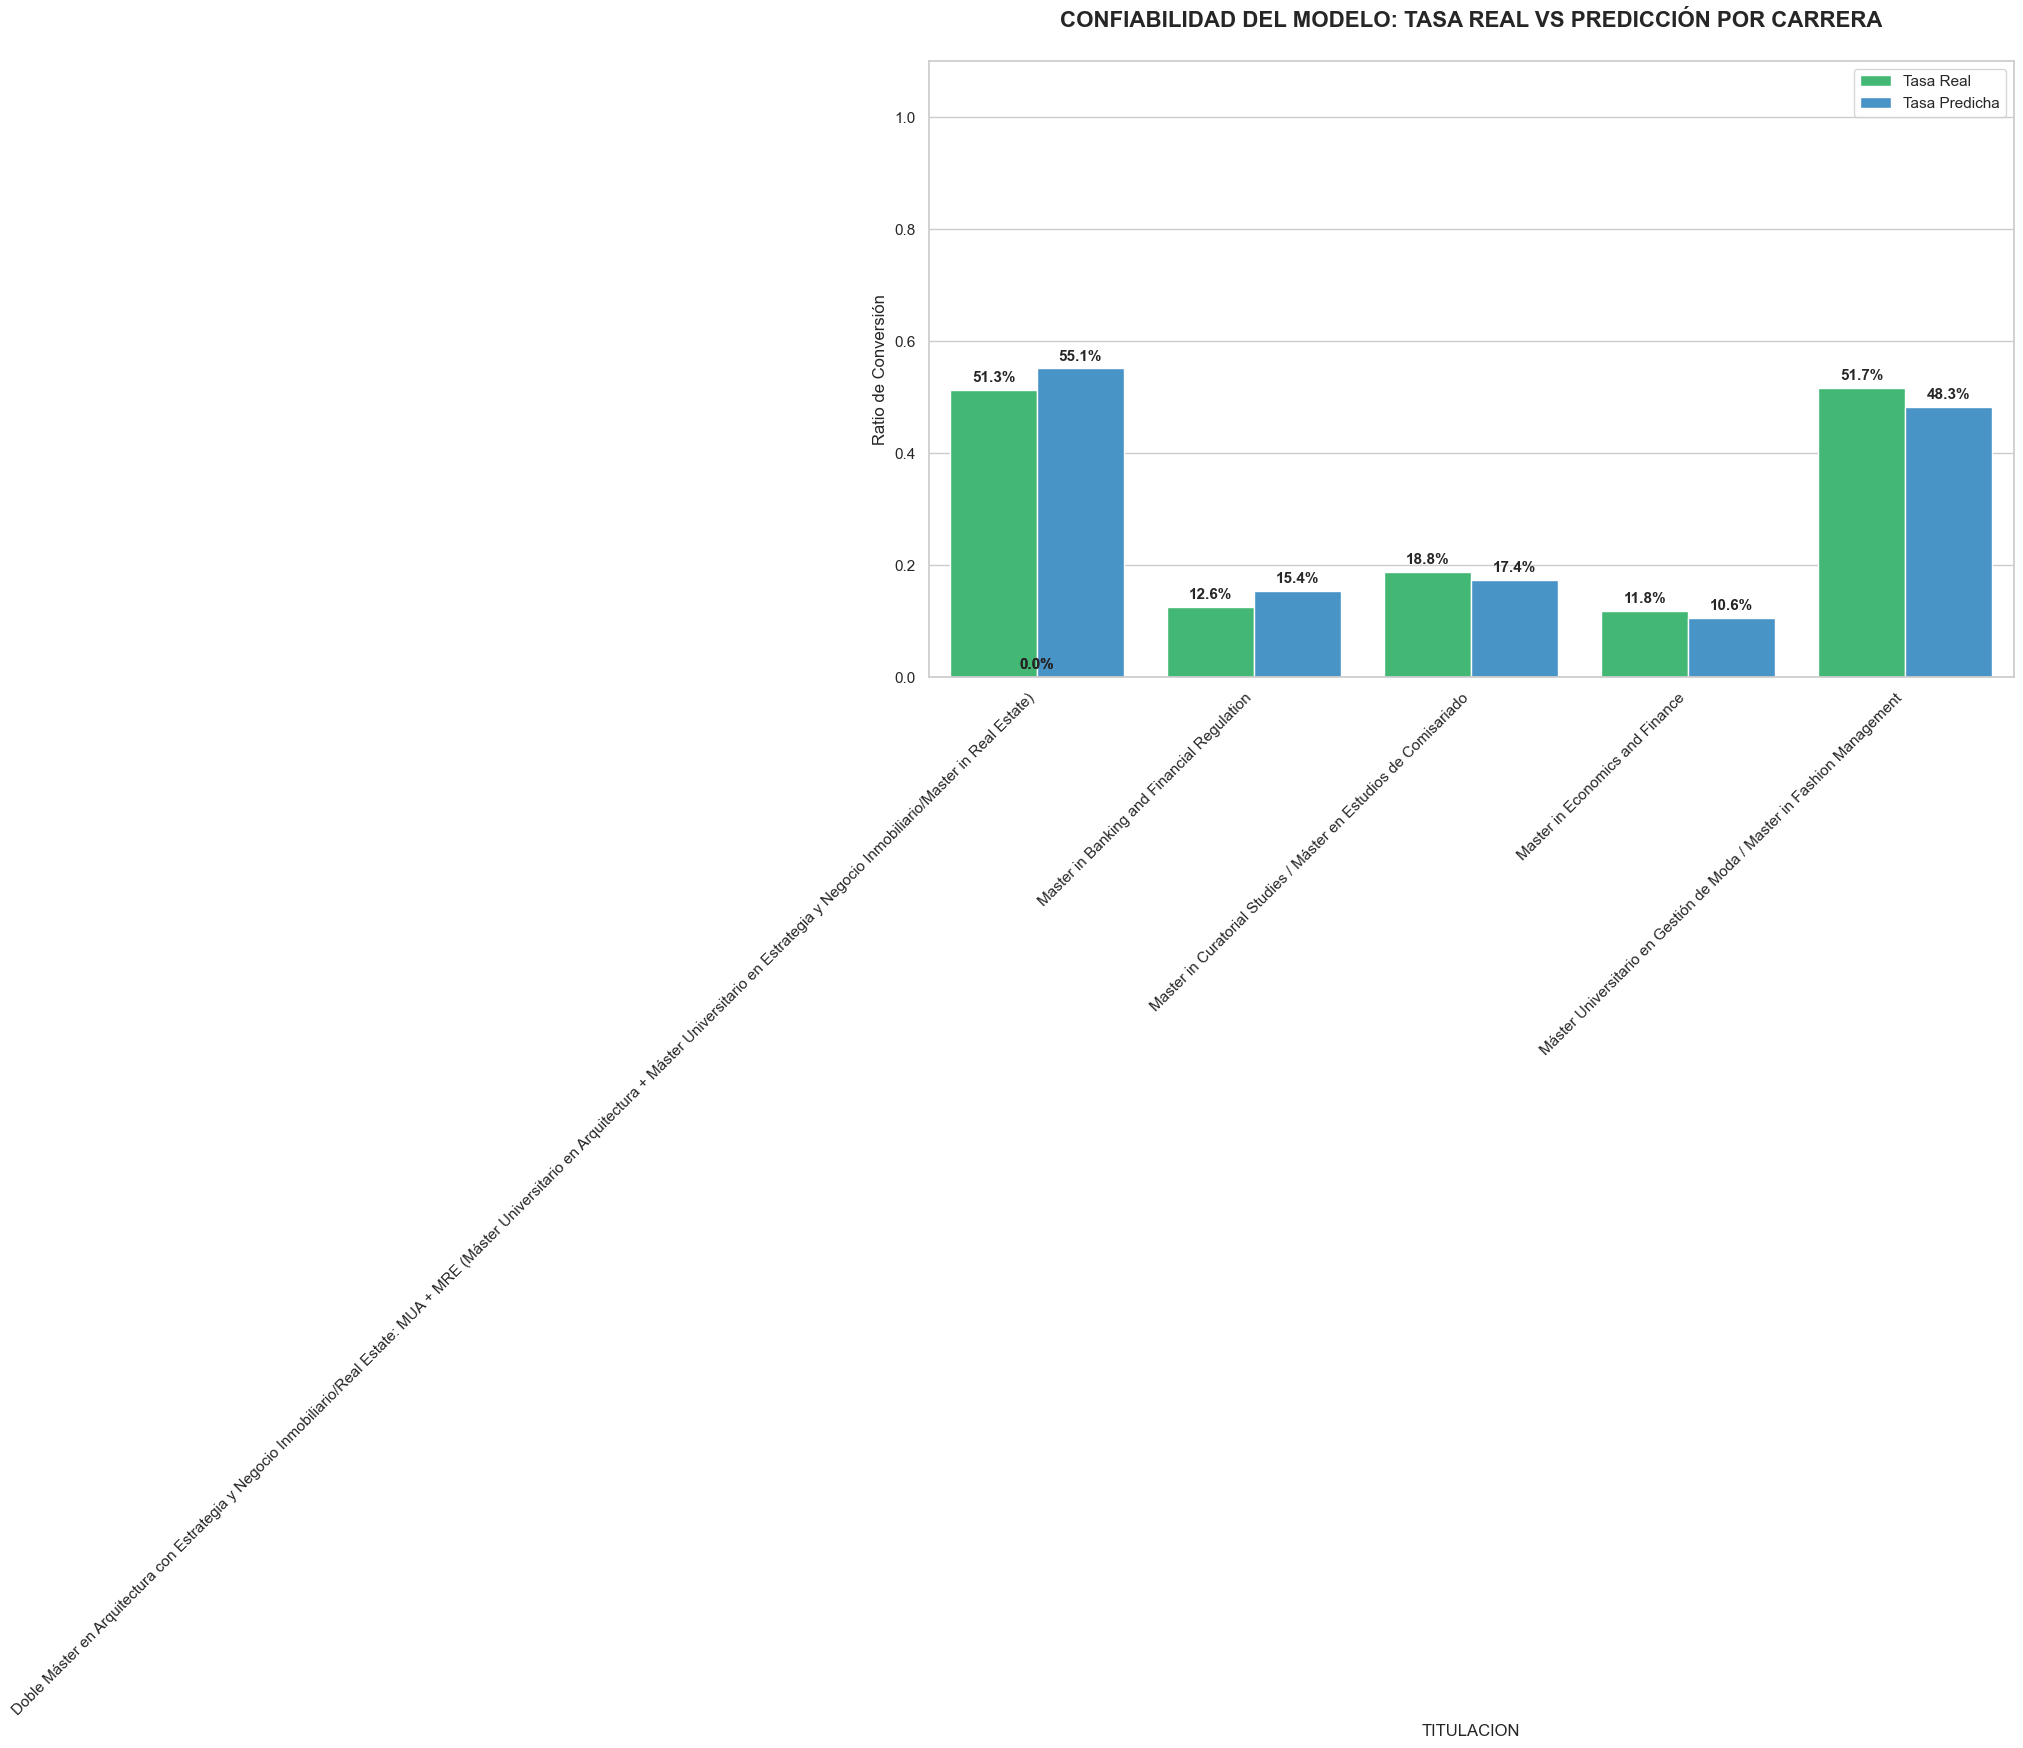

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
import warnings

warnings.filterwarnings('ignore')

# --- 1. PREPARACIÓN DE DATOS POR ID ÚNICO ---
# Agrupamos por ID para que cada oportunidad cuente solo una vez
# Target: tomamos el max (si alguna vez fue 1, es matrícula)
# Prediction_label: tomamos el último estado predicho
# Prob_matricula: tomamos la media o la última (usaremos la real normalizada)

df_unique = df.sort_values(['ID', 'STAGENAME']).groupby('ID').agg({
    'target': 'max',
    'prediction_label': 'last',
    'prediction_score': 'last',
    'TITULACION': 'first'
}).reset_index()

# Re-calculamos la probabilidad real sobre el set único
df_unique['prob_matricula_real'] = df_unique.apply(
    lambda x: x['prediction_score'] if x['prediction_label'] == 1 else (1 - x['prediction_score']), 
    axis=1
)

# --- 2. FUNCIÓN DE VIRTUDES DEL MODELO (Basada en IDs Únicos) ---
def analizar_virtudes_modelo(data):
    y_real = data['target']
    y_pred = data['prediction_label']
    y_prob = data['prob_matricula_real']
    
    acc = accuracy_score(y_real, y_pred)
    auc = roc_auc_score(y_real, y_prob)
    prec = precision_score(y_real, y_pred)
    rec = recall_score(y_real, y_pred)
    
    print("-" * 50)
    print("      VIRTUDES DEL MODELO (SOBRE OPORTUNIDADES ÚNICAS)")
    print("-" * 50)
    print(f"✅ Exactitud Global (Accuracy): {acc:.2%}")
    print(f"🎯 Área bajo la curva (AUC): {auc:.4f}")
    print(f"📊 Precisión de Matrícula: {prec:.2%}")
    print(f"📈 Capacidad de Captación (Recall): {rec:.2%}")
    print("-" * 50)

analizar_virtudes_modelo(df_unique)

# --- 3. COMPARATIVA POR TITULACIÓN (TOP 5) ---
top_5_tit = df_unique.groupby('TITULACION')['ID'].nunique().nlargest(5).index
df_top5_unique = df_unique[df_unique['TITULACION'].isin(top_5_tit)]

# Ahora las medias son reales (alumnos matriculados / alumnos totales)
comparativa_tit = df_top5_unique.groupby('TITULACION')[['target', 'prediction_label']].mean().reset_index()
df_plot = comparativa_tit.melt(id_vars='TITULACION', var_name='Tipo', value_name='Tasa')
df_plot['Tipo'] = df_plot['Tipo'].replace({'target': 'Tasa Real', 'prediction_label': 'Tasa Predicha'})

# --- 4. GRÁFICO FINAL ---
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='TITULACION', y='Tasa', hue='Tipo', data=df_plot, palette=['#2ecc71', '#3498db'])

# Añadir etiquetas de porcentaje
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1%}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', xytext = (0, 9), 
                textcoords = 'offset points', fontsize=11, fontweight='bold')

plt.title('CONFIABILIDAD DEL MODELO: TASA REAL VS PREDICCIÓN POR CARRERA', fontsize=16, fontweight='bold', pad=25)
plt.ylabel('Ratio de Conversión')
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

Aquí se puede observar que las tasas de matriculación con la variable predicha son muy muy parecidas a las reales y, ligeramente inferiores, excepto en el caso del máster con más demanda.

## 4. Evolución de la probabilidad de matrícula por etapa

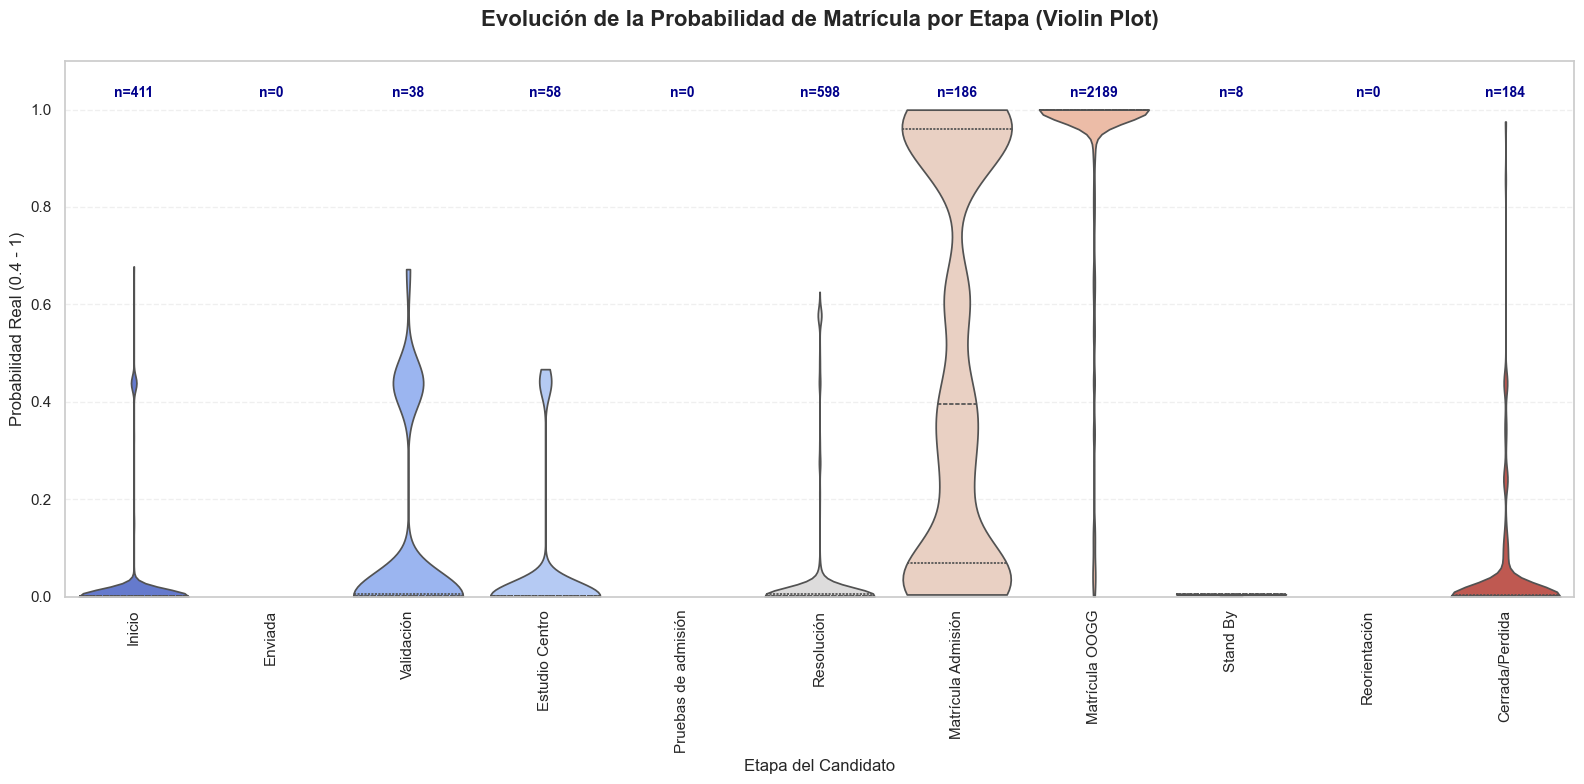

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# 1. Configuración de limpieza
warnings.filterwarnings('ignore')

# 2. Preparación de datos y cálculo de Probabilidad Real
# Interpretación: 0 (No matrícula) a 1 (Matrícula segura)
df['STAGENAME'] = df['STAGENAME'].astype(str).str.strip()

# Si el modelo predijo 0, la probabilidad real es (1 - score de confianza)
df['prob_matricula_real'] = df.apply(
    lambda x: x['prediction_score'] if x['prediction_label'] == 1 else (1 - x['prediction_score']), 
    axis=1
)

# 3. Definición y filtrado de etapas lógicas
etapas_orden = [
    'Inicio', 'Enviada', 'Validación', 'Estudio Centro', 
    'Pruebas de admisión', 'Resolución', 'Matrícula Admisión', 
    'Matrícula OOGG', 'Stand By', 'Reorientación', 'Cerrada/Perdida'
]

# Filtramos solo las etapas definidas y forzamos el orden categórico
df_filtered = df[df['STAGENAME'].isin(etapas_orden)].copy()
df_filtered['STAGENAME'] = pd.Categorical(df_filtered['STAGENAME'], categories=etapas_orden, ordered=True)

# 4. Creación del Gráfico de Violín
plt.figure(figsize=(16, 8))

ax = sns.violinplot(
    x='STAGENAME', 
    y='prob_matricula_real', 
    data=df_filtered, 
    palette='coolwarm', 
    inner='quartile', 
    bw_adjust=.5,
    cut=0 
)

# 5. Añadir el conteo de oportunidades (n=X) sobre cada violín
counts = df_filtered['STAGENAME'].value_counts().reindex(etapas_orden)
for i, count in enumerate(counts):
    if not pd.isna(count):
        ax.text(i, 1.02, f'n={int(count)}', ha='center', va='bottom', 
                fontweight='bold', size=10, color='darkblue')

# 6. Estética y Formato
plt.title('Evolución de la Probabilidad de Matrícula por Etapa (Violin Plot)', fontsize=16, fontweight='bold', pad=25)
plt.xlabel('Etapa del Candidato', fontsize=12)
plt.ylabel('Probabilidad Real (0.4 - 1)', fontsize=12)

# Rotación vertical de etiquetas para evitar solapamiento
plt.xticks(rotation=90)

# Foco en el área de decisión
plt.ylim(0, 1.1) 
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

Aquí se pueden ver que hay etapas en las que claramente, la probabilidad de matrícula son muy bajas. En cambio, en la etapa de Matrícula admisión, ya se ven probabilidades más extendidas, y que es una de las etapas críticas, ya que hay muchos valores bajos como altos. Sin embargo, en la etapa Matrícula OOGG ya se tienen todas las probabilidades concentradas en valores muy altos.

## Distribución de probabilidades en el top 5 de titulaciones

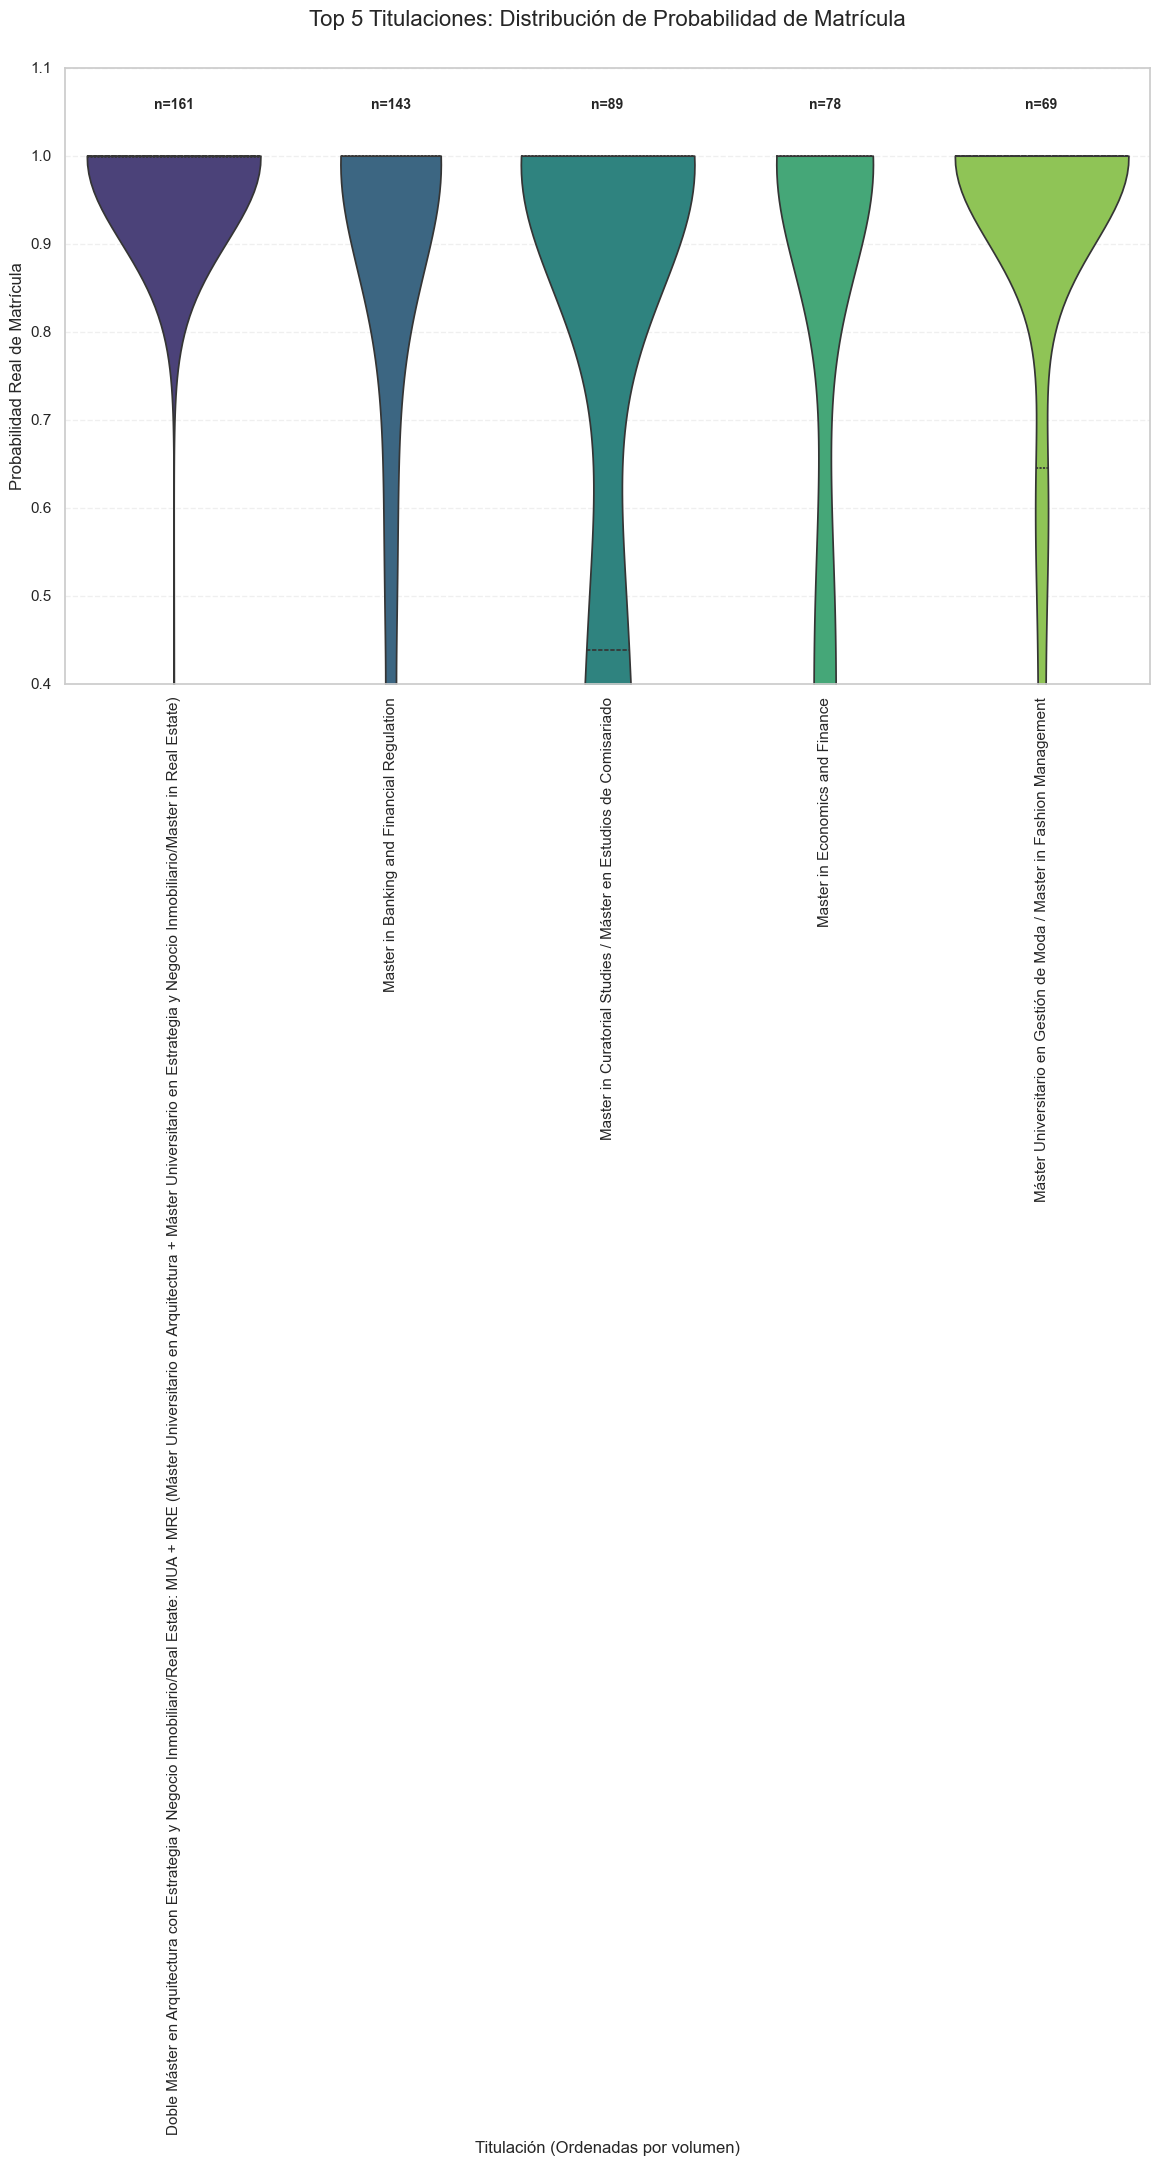

In [ ]:
# 1. Identificar el Top 5 de Titulaciones por IDs únicos
top_5_titulaciones = df.groupby('TITULACION')['ID'].nunique().nlargest(5).index
df_top5 = df[df['TITULACION'].isin(top_5_titulaciones)].copy()

# 2. Gráfico de Violín para el Top 5
plt.figure(figsize=(14, 8))

ax = sns.violinplot(
    x='TITULACION', 
    y='prob_matricula_real', 
    data=df_top5,
    palette='viridis',
    inner='quartile',
    cut=0
)

# Añadir n=X (IDs únicos) encima de cada violín
counts_tit = df_top5.groupby('TITULACION')['ID'].nunique()
for i, tit in enumerate(top_5_titulaciones):
    n = counts_tit[tit]
    ax.text(i, 1.05, f'n={n}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.title('Top 5 Titulaciones: Distribución de Probabilidad de Matrícula', fontsize=16, pad=30)
plt.ylabel('Probabilidad Real de Matrícula')
plt.xlabel('Titulación (Ordenadas por volumen)')
plt.ylim(0.4, 1.1)
plt.xticks(rotation=90) # Verticales para que se lean los grados largos
plt.grid(axis='y', linestyle='--', alpha=0.3)

plt.show()

Aquí se puede obserbar que los patrones son muy parecidos entre sí:

- Hay perfiles muy distintos entre sí con probabilidades altas. Y suele pasar en todos los másters.

## Importancia de variables

Transformation Pipeline and Model Successfully Loaded
⚠️ Ajustando: Modelo tiene 17 variables pero se detectaron 18 nombres.


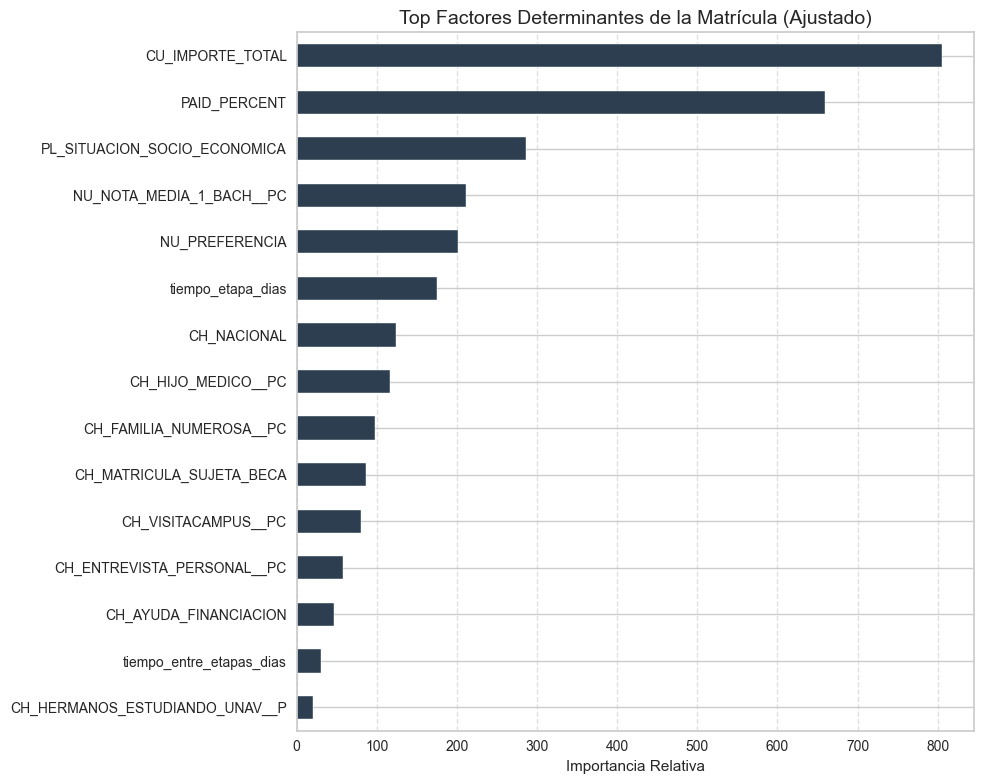

In [ ]:

from pycaret.classification import (load_model,
    setup, compare_models, tune_model,
    predict_model, plot_model, save_model
)

ruta_modelo = r"C:\Users\0017655\Downloads\modelo_final_master 7"
modelo = load_model(ruta_modelo)
# 2. Inicializar el experimento (Necesario para que plot_model funcione)
# 'data' debe ser el DataFrame que estás usando para la PoC
# 'target' debe ser el nombre de la columna que quieres predecir
s = setup(data = df, target = 'target', session_id = 123, verbose=False)
import pandas as pd
import matplotlib.pyplot as plt

# 1. Obtener el modelo final
last_step_name = list(modelo.named_steps.keys())[-1]
final_model = modelo.named_steps[last_step_name]

# 2. Extraer valores de importancia
importancia_valores = final_model.feature_importances_
n_features = len(importancia_valores)

# 3. Intentar recuperar nombres, si no, crear genéricos
try:
    # Intentamos obtener los nombres que el transformador final dejó
    feature_names = modelo.feature_names_in_
    
    # Si la longitud sigue sin coincidir, ajustamos
    if len(feature_names) != n_features:
        print(f"⚠️ Ajustando: Modelo tiene {n_features} variables pero se detectaron {len(feature_names)} nombres.")
        if len(feature_names) > n_features:
            feature_names = feature_names[:n_features]
        else:
            feature_names = list(feature_names) + [f"Extra_Feature_{i}" for i in range(n_features - len(feature_names))]
except:
    feature_names = [f"Variable_{i}" for i in range(n_features)]

# 4. Crear el gráfico con seguridad
importancias = pd.Series(importancia_valores, index=feature_names)

plt.figure(figsize=(10, 8))
# Tomamos las 15 más importantes (o el máximo disponible)
top_n = min(15, n_features)
importancias.nlargest(top_n).sort_values().plot(kind='barh', color='#2c3e50')

plt.title('Top Factores Determinantes de la Matrícula (Ajustado)', fontsize=14)
plt.xlabel('Importancia Relativa')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

Aquí, al igual que en grado, las variables más importantes son: el importe total de la matrícula, el pocentaje que ha pagado y la situación socioeconómica. Seguido de la nota de bachillerato, la preferencia y su situación social; es decir, si es hijo de médico, familia numerosa, etc.